# Importing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
!pip install mlxtend --upgrade --no-deps

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import RobustScaler
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from statlearning import plot_coefficients
from statlearning import plot_dist
from xgboost import XGBRegressor
from scipy import stats
import scipy.stats as st

!pip install mplleaflet
import mplleaflet

Requirement already up-to-date: mlxtend in /usr/local/lib/python3.7/dist-packages (0.18.0)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Import data**

The longitude/latitude pairs from the test and train datasets were converted into a list of addresses using an external website. The suburbs were extracted and the median unit price and mean airbnb price was found for each suburb using external data. 

In [ ]:
auxiliary = pd.read_csv("auxiliary.csv")
data = pd.read_csv("train.csv").merge(auxiliary[:2000], how = 'left')
objective = pd.read_csv("test.csv").merge(auxiliary[2000:], how = 'left')

df = pd.concat([data, objective], keys = ["data", "objective"]).set_index('Id')

# Data Cleaning

**Ordinal encoding**

In [ ]:
df['cancellation_policy'] = df.cancellation_policy.map({'flexible': 4,'moderate': 3,'strict_14_with_grace_period': 2,'super_strict_30': 1,'super_strict_60': 0})
df['host_response_time'] = df.host_response_time.map({'a few days or more': 0, 'within a day': 1,'within a few hours ': 2,'within an hour': 3})

**Category clustering**

In [ ]:
df['property_type'] = np.where(df['property_type'].str.contains('House'), "House", (np.where(df['property_type'].str.contains('Apartment'), "Apartment", (np.where(df['property_type'].str.contains('Townhouse'), "Townhouse", "Other")))))
df['bed_type'] = np.where(df['bed_type'].str.contains('Real Bed'), "Real Bed", "Other")

**Drop redundant variables**

In [ ]:
redundant_variables = [ 
                       
    'suburb']

df.drop(columns = redundant_variables, inplace = True)

**Boolean encoding**

In [ ]:
boolean_variables = [
                     
    'host_is_superhost', 
    'host_identity_verified',
    'instant_bookable',
    'require_guest_profile_picture',
    'require_guest_phone_verification']
 
for i, boolean_variable in enumerate(boolean_variables):
  df[boolean_variable] = df[boolean_variable].map({'f':0,'t':1})

**Nominal encoding**

In [ ]:
dummy_variables = [ 
                   
    'property_type', 
    'room_type', 
    'bed_type']

df = pd.get_dummies(data = df, columns = dummy_variables, dummy_na = True, drop_first = True, dtype = 'int64')
df = df.loc[:, (df != 0).any(axis = 0)]
df.columns = df.columns.str.replace(' ','_')

**Map NaN to 0 where appropriate**

In [ ]:
nan_zero_variables = [
                   
    'bedrooms', 
    'beds',
    'cleaning_fee']

for i, nan_zero_variable in enumerate(nan_zero_variables):
  df[nan_zero_variable].fillna(0, inplace = True)

**Convert percentages to proportions**

In [ ]:
df['review_scores_rating'] = df['review_scores_rating'] / 100

**Change data types**

In [ ]:
float_variables = [
                   
    'guests_included', 
    'number_of_reviews',
    'cancellation_policy']

for i, float_variable in enumerate(float_variables):
  df[float_variable] = df[float_variable].astype(float)

**Delete erroneous values**

In [ ]:
df['maximum_nights'].replace(1125, np.NaN, inplace = True)

**Set allowable maximum**

In [ ]:
df['beds'] = df['beds'].where(df['beds'] <= 20, 20)
df['guests_included'] = df['guests_included'].where(df['guests_included'] <= 20, 20)

In [ ]:
df

price  host_response_time  ...  room_type_Shared_room  bed_type_Real_Bed
Id                               ...                                          
2000  199.0                 3.0  ...                      0                  1
2001   95.0                 NaN  ...                      0                  1
2002  156.0                 3.0  ...                      0                  1
2003  100.0                 3.0  ...                      0                  1
2004  100.0                 1.0  ...                      0                  1
...     ...                 ...  ...                    ...                ...
1995    NaN                 NaN  ...                      0                  1
1996    NaN                 NaN  ...                      0                  1
1997    NaN                 0.0  ...                      0                  1
1998    NaN                 0.0  ...                      0                  1
1999    NaN                 NaN  ...                      0                  1

[4000 rows x 41 columns]

# Transformations

**Seperate bimodal distributions (peak at 0)**

Some variables follow a normal distribution, but have an additional peak at 0 (or 1). For example, many airbnb's do not charge a cleaning fee, but if they do, it follows a normal distribution. The following code splits the variable into two new variables. One is a float variable that caputures the normal part by simply dropping the peak (convert zeros into NaN). The second varibale is a boolean varibable that caputures whether the value is part of the peak. 

In [ ]:
bimodal_variables = [
                     
    'cleaning_fee', 
    'security_deposit', 
    'extra_people']

for i, bimodal_variable in enumerate(bimodal_variables):
  df[''.join([bimodal_variable, "_yes"])] = (df[bimodal_variable].values > 0).astype(int)
  df[bimodal_variable].replace(0, np.nan, inplace = True)

**Seperate bimodal distributions (peak at 1)**

In [ ]:
bimodal_variables = [
                     
    'host_acceptance_rate', 
    'host_response_rate', 
    'review_scores_rating']

for i, bimodal_variable in enumerate(bimodal_variables):
  df[''.join([bimodal_variable, "_perfect"])] = (df[bimodal_variable].values < 1).astype(int)
  df[bimodal_variable].replace(1, np.nan, inplace = True)

**Apply power transformations to negatively skewed variables** (done by trial and error)


In [ ]:
df['host_acceptance_rate'] = np.power(df['host_acceptance_rate'],4)
df['review_scores_rating'] = np.power(df['review_scores_rating'],10)
df['host_response_rate'] = np.power(df['host_response_rate'],5)

**Apply log1p transformations to positively skewed variables** 

The log1p transformation is used instead of the log transformation because many variables contain zeros (log of 0 is undefined). The log1p function adds 1 to each value then performs the natural log transformation. The inverse of log1p is exp1m  

In [ ]:
pos_skew_variables = [
                      
    'price',
    'cleaning_fee',
    'security_deposit',
    'extra_people',
    'median_price',
    'host_listings_count',
    'maximum_nights',
    'minimum_nights',
    'accommodates',
    'median_abnb',
    'bathrooms',
    'beds',
    'bedrooms']

for i, pos_skew_variable in enumerate(pos_skew_variables):
  df[''.join(["log1p_", pos_skew_variable])] = np.log1p(df[pos_skew_variable])
  df.drop(columns = pos_skew_variable, inplace = True)

**Find z-score from percentiles for the tightly clustered variables**

Some variables are so highly skewed that they seem to follow a hyperbolic function. Therefore, it is impossible to normalise them with a non-linear transformation. For these variables, it is possible to convert each into a percentile (p-value). These new values can then be normalised by converting the p values into z-scores. 

In [ ]:
hyperbolic_variables = [
                        
    'host_response_time',
    'review_scores_accuracy',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value']

for i, hyperbolic_variable in enumerate(hyperbolic_variables):
  df[''.join(["zscore_", hyperbolic_variable])] = st.norm.ppf(df[hyperbolic_variable].rank(pct = True))
  df.drop(columns = hyperbolic_variable, inplace = True)

**Reciprocals**

In [ ]:
reciprocal_variables = [
                        
    'reviews_per_month', 
    'number_of_reviews']

for i, reciprocal_variable in enumerate(reciprocal_variables):
  df[''.join(["reciprocal_", reciprocal_variable])] = np.reciprocal(df[reciprocal_variable]+1).rank(pct = True)
  df.drop(columns = reciprocal_variable, inplace = True)

In [ ]:
df.to_csv('modified.csv')

# Exploratory Data Analysis



**Visualise the skew of resulting variables**

Ideally, the histograms for the contineous variables should be gaussian 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


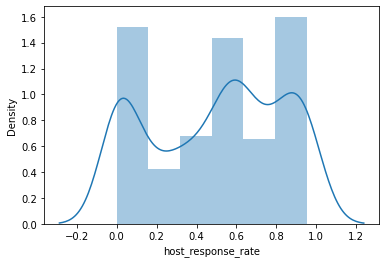

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


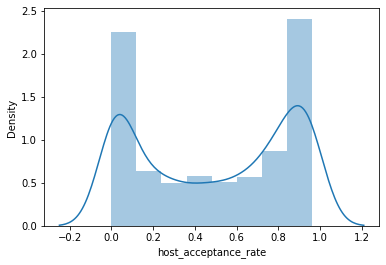

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


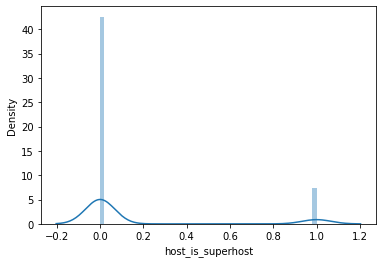

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


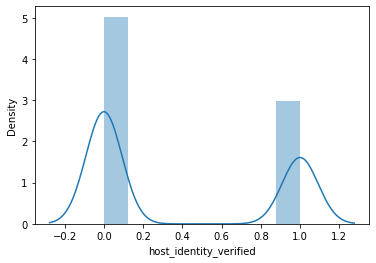

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


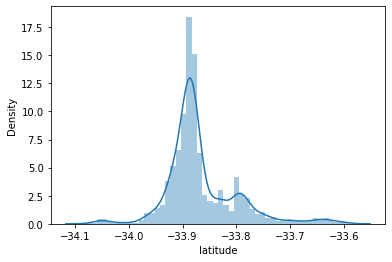

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


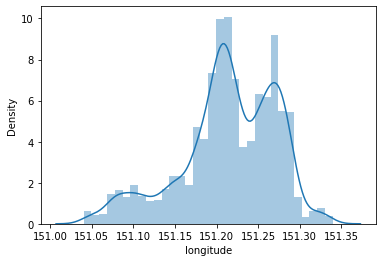

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


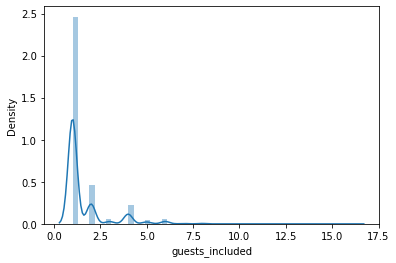

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


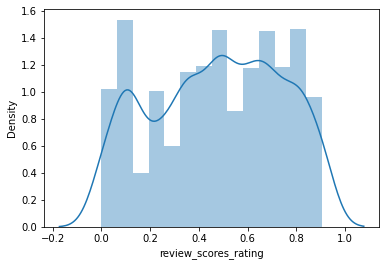

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


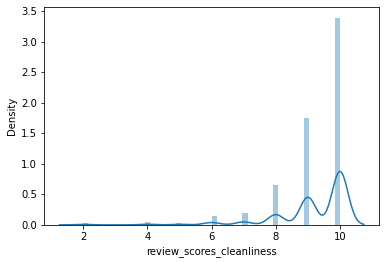

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


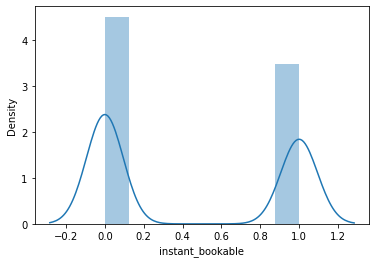

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


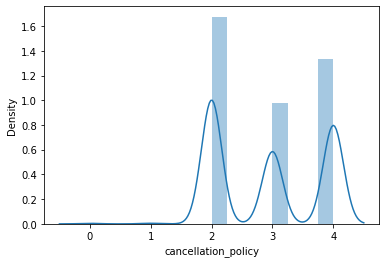

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


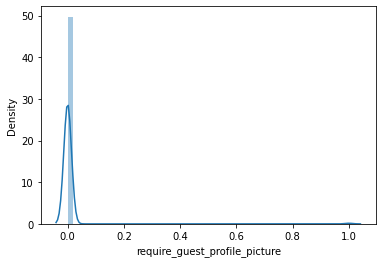

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


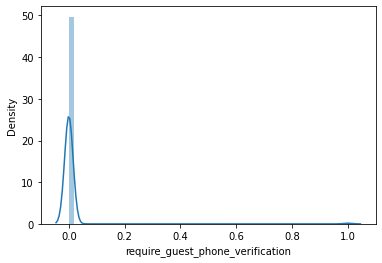

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


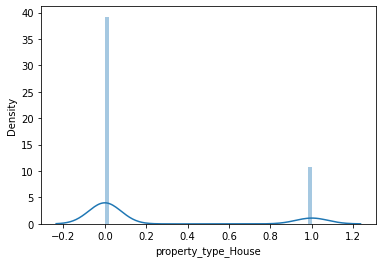

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


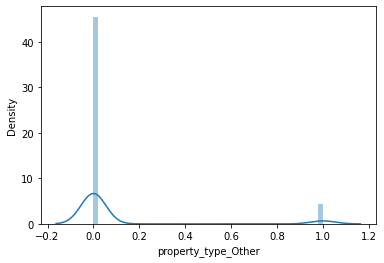

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


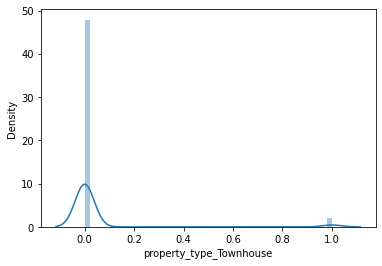

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


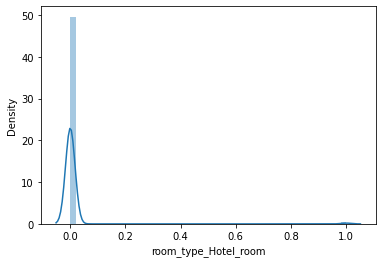

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


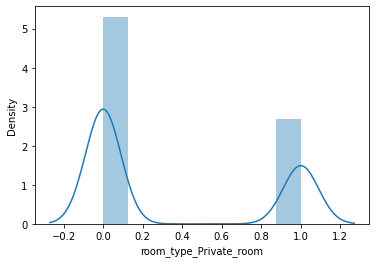

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


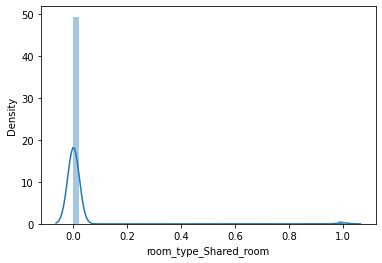

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


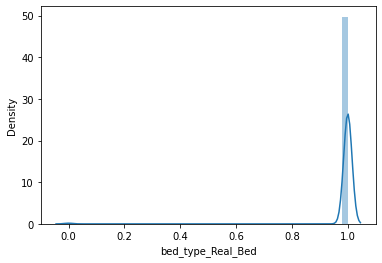

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


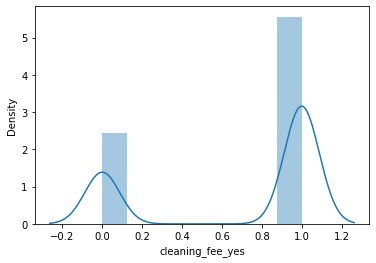

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


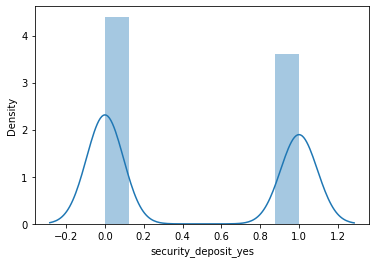

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


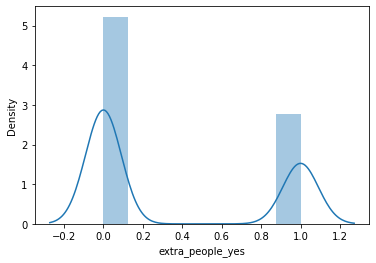

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


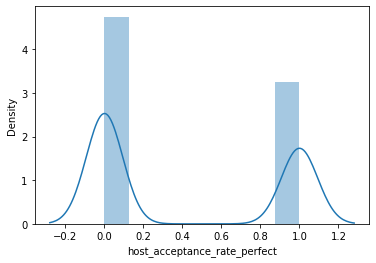

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


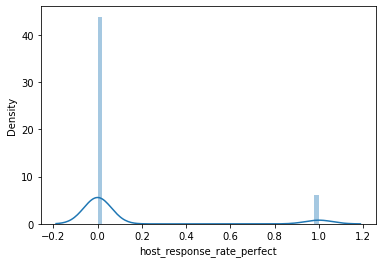

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


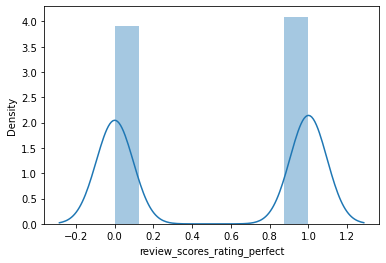

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


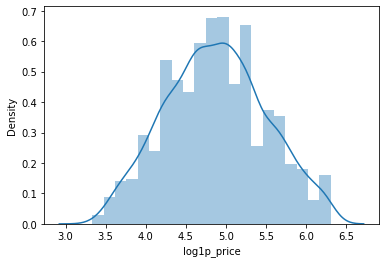

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


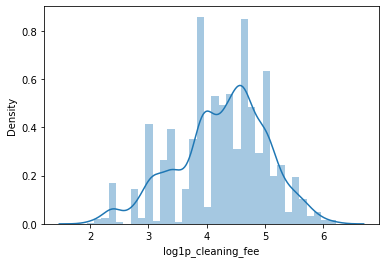

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


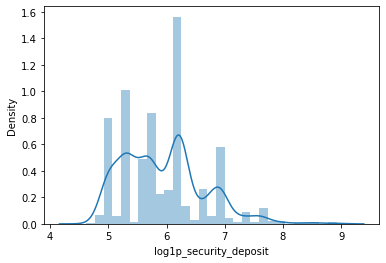

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


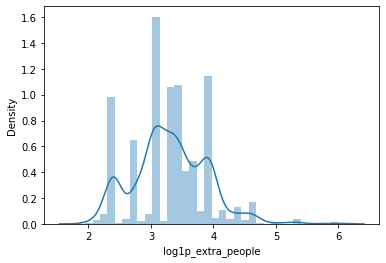

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


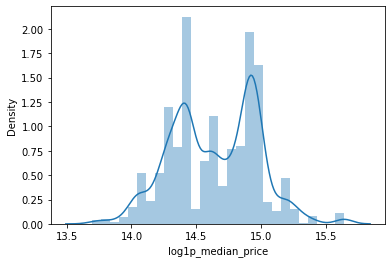

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


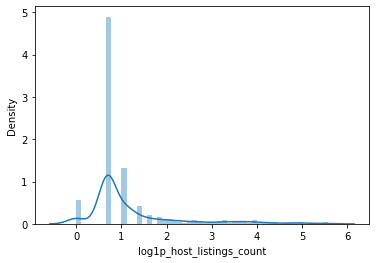

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


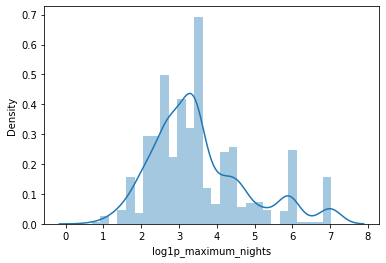

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


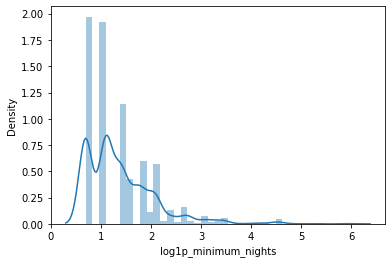

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


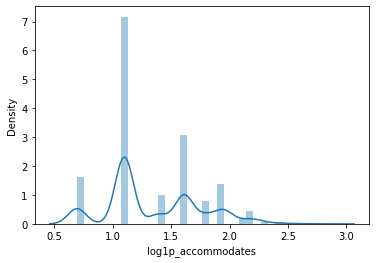

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


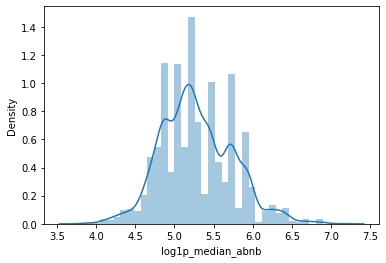

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


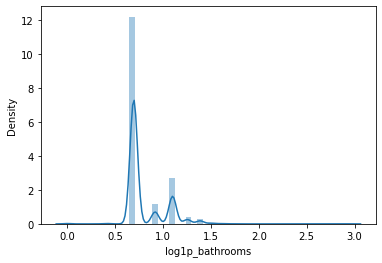

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


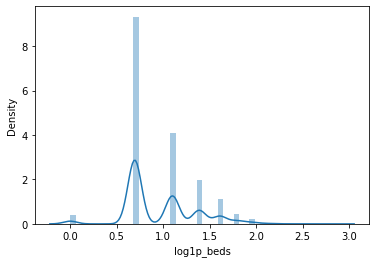

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


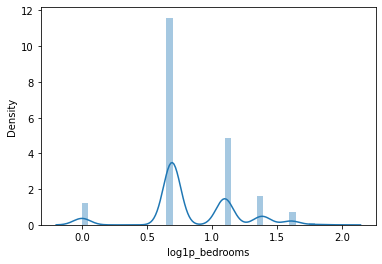

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


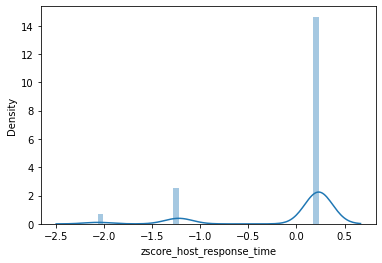

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


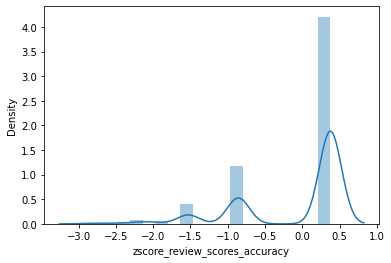

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


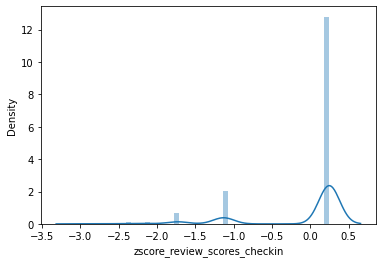

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


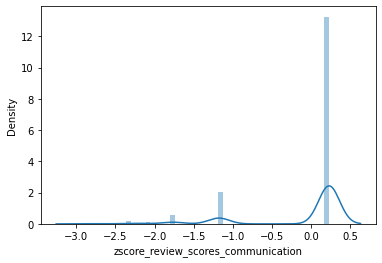

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


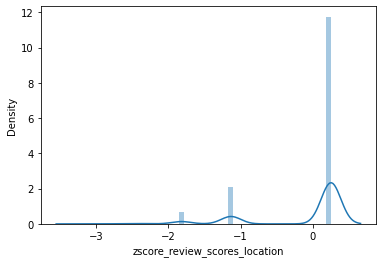

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


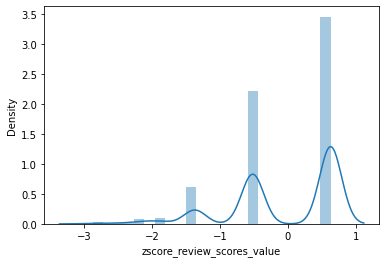

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


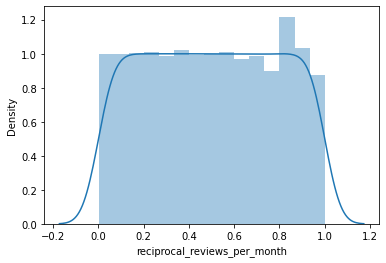

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


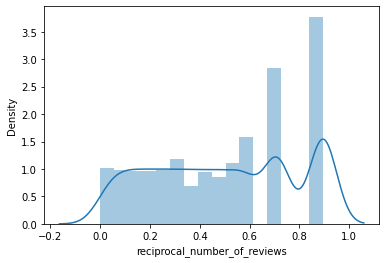

In [ ]:
numeric_data = df._get_numeric_data()
for i in numeric_data.columns:
  sns.distplot(numeric_data[i])
  plt.show()

**Correlation matrix**

In [ ]:
matrix = pd.DataFrame(df.corr()['log1p_price'])
matrix['abs'] = np.abs(matrix['log1p_price'])
matrix = matrix.sort_values('abs', ascending = False).drop(columns = ['abs'])[1:].dropna()
matrix.head(10)

log1p_price
log1p_accommodates         0.699359
room_type_Private_room    -0.675796
log1p_cleaning_fee         0.663705
log1p_beds                 0.565635
log1p_bedrooms             0.531813
log1p_security_deposit     0.391649
guests_included            0.328131
log1p_bathrooms            0.314081
log1p_median_abnb          0.279031
log1p_extra_people         0.278442

**Interaction**

Below, VDA methods are used for determining possible interactions. The graphs plot one float variable against 'log1p_price'. The scatter plot is then split according to a second variable (which is boolean) and two lines of best fit are graphed. If the lines are non parallel, it suggests that there is some interaction. Because there is a very large number of potential interaction variables, the code only looks at the n-number of variables with the greatest corrolation with 'log1p_price'. The code shows n float variables against n booleans, resulting in n-squared graphs. 

For the sake of reducing run-time, n = 1 is selected to speed up this code. If you actually want to visualise the interactions, use a higher n (like 10, which would produce 100 graphs).

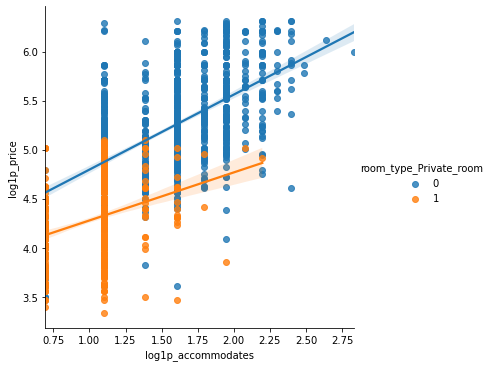

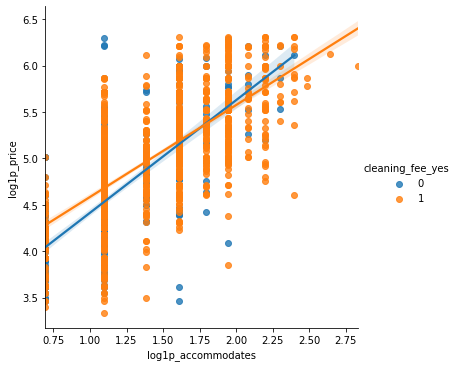

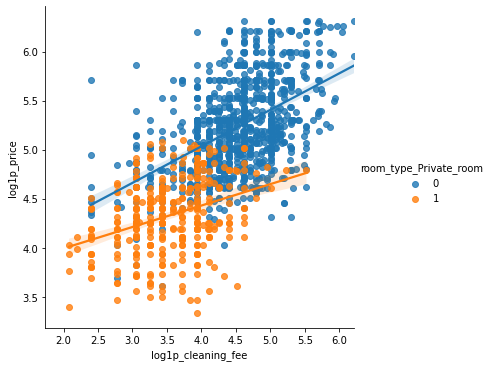

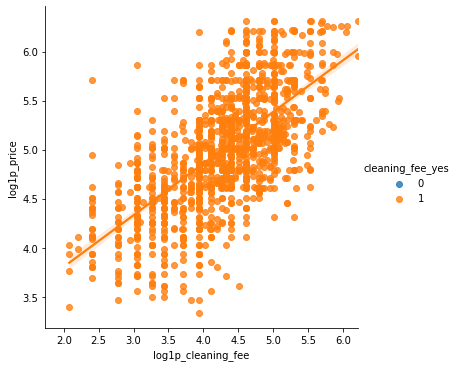

In [ ]:
n = 2

boolean_variables = df[:2000].select_dtypes(include='int64')
boolean_variables = boolean_variables[boolean_variables.columns[(boolean_variables.mean() > 0.25) & (boolean_variables.mean() < 0.75)]]
boolean_variables = boolean_variables.merge(df['log1p_price'], left_index = True, right_index = True)
continuous_variables = df[:2000].select_dtypes(include='float')

matrix_continuous_variables = pd.DataFrame(continuous_variables.corr()['log1p_price'])
matrix_continuous_variables['abs'] = np.abs(matrix_continuous_variables['log1p_price'])
matrix_continuous_variables = matrix_continuous_variables.sort_values('abs', ascending = False).drop(columns = ['abs'], index = 'log1p_price')
continuous_variables = matrix_continuous_variables.iloc[:n].index.values

matrix_boolean_variables = pd.DataFrame(boolean_variables.corr()['log1p_price'])
matrix_boolean_variables['abs'] = np.abs(matrix_boolean_variables['log1p_price'])
matrix_boolean_variables = matrix_boolean_variables.sort_values('abs', ascending = False).drop(columns = ['abs'], index = 'log1p_price')
boolean_variables = matrix_boolean_variables.iloc[:n].index.values

for i in range(len(continuous_variables)):
  for j in range(len(boolean_variables)):
    sns.lmplot(y = 'log1p_price', x = str(continuous_variables[i]), data = df, hue = str(boolean_variables[j]))

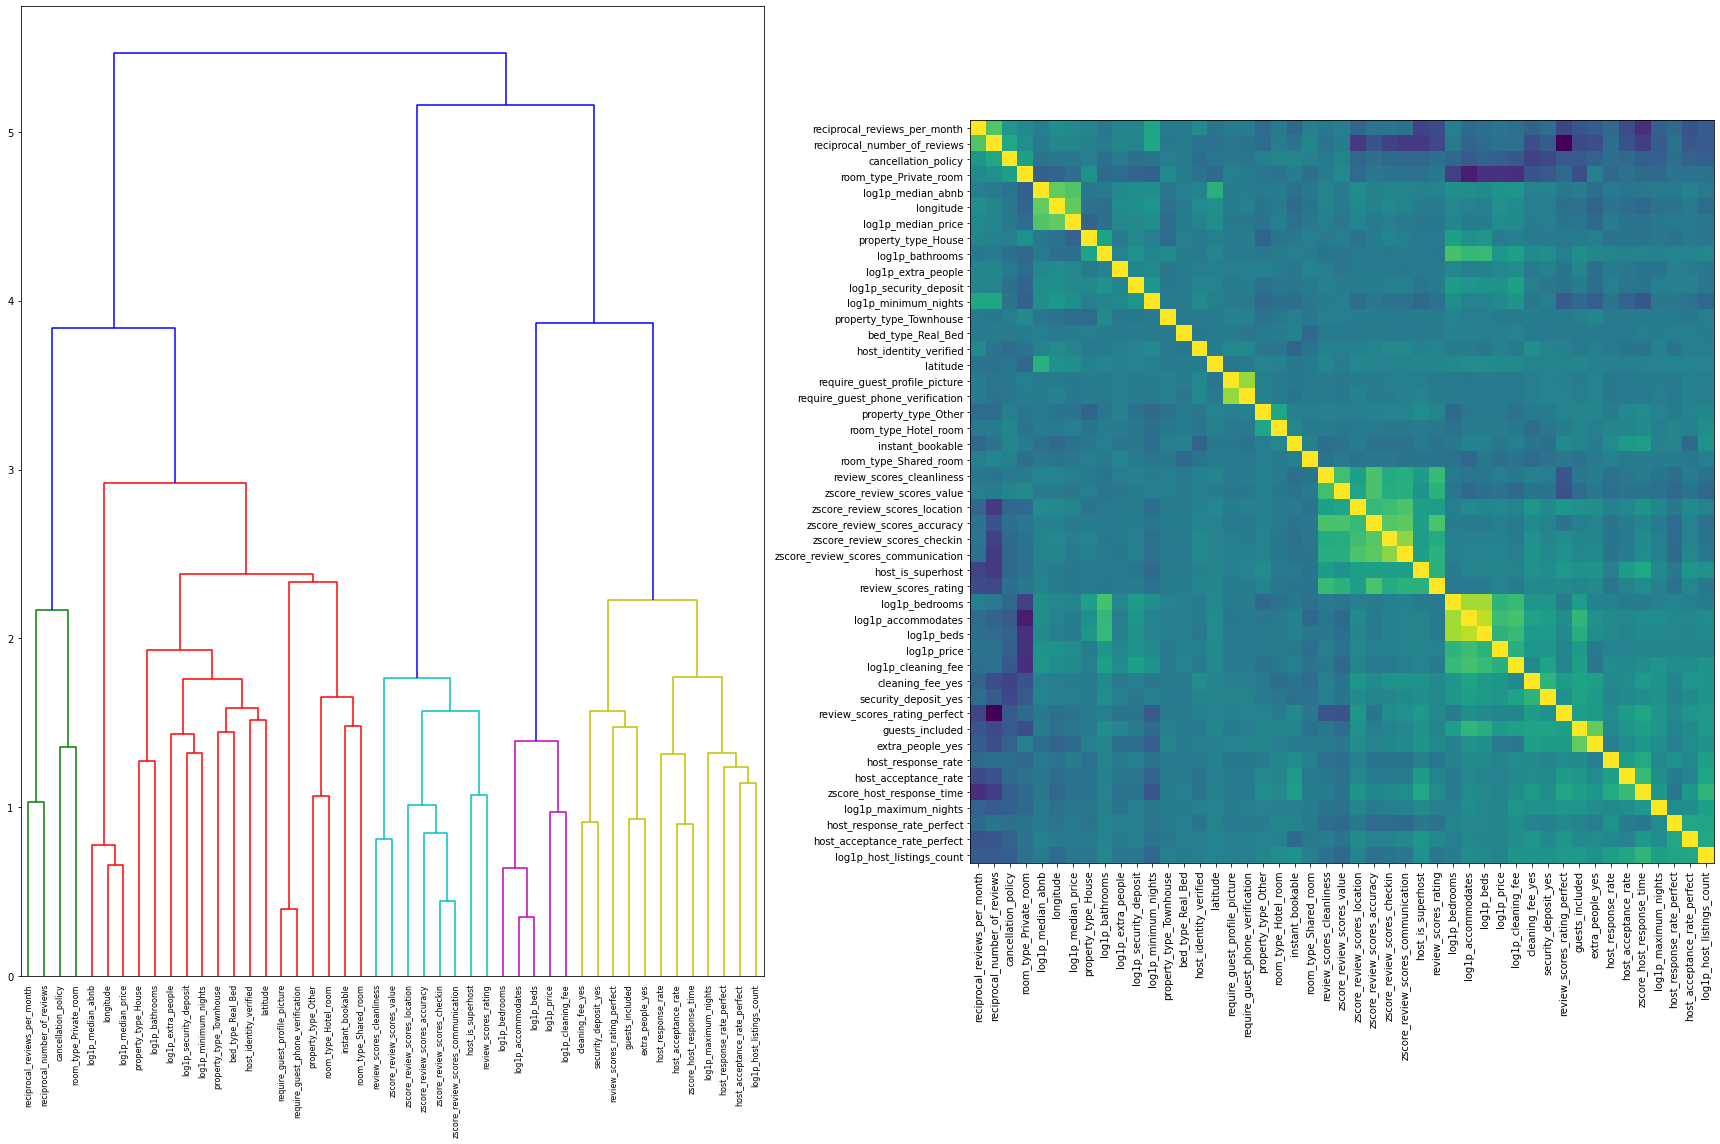

In [ ]:
# Visualise Multicollinearity

df1 = df.replace([np.inf, -np.inf], np.nan)
df1 = df1.fillna(df.mean())
StandardScaler().fit_transform(df1)
df1 = df1.loc[:, (df1 != 0).any(axis = 0)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16))
corr = spearmanr(df1).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=df1.keys(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [ ]:
ax = plt.scatter(df['longitude'][:2000], df['latitude'][:2000], s = 20, c = df['log1p_price'][:2000], edgecolors = 'none', cmap = plt.get_cmap('coolwarm'), alpha = 1)
mplleaflet.display(fig = ax.figure)

# Feature Engineering

**Cluster longitude and latitude**

The airbnb's are clustered into k-number of geographic regions and the resulting variance is determined. The aim is to use an elbow-plot to determine the optimal number of regions. However, the optimal number is not obvious from the plot. 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Score'), Text(0.5, 0, 'K Means')]

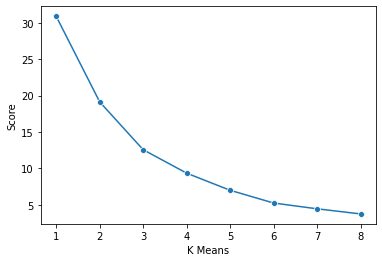

In [ ]:
Score = []
K = range(1, 9)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(df[['latitude', 'longitude']])
    Score.append(kmeanModel.inertia_)

sns.lineplot(K, Score, marker = "o").set(xlabel = "K Means", ylabel = "Score")


**Select k-clusters**

The 2D scatterplot is a map of Sydney. The regions of Sydney are converted into k-number of dummy variables.

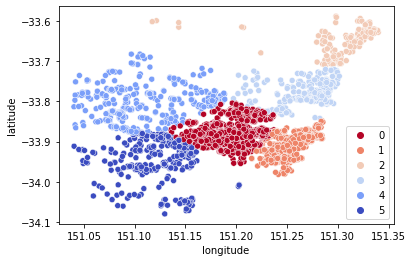

In [ ]:
kmeanModel = KMeans(n_clusters = 6)
kmeanModel.fit(df[['latitude', 'longitude']])
df['region'] = kmeanModel.labels_
df = pd.get_dummies(data = df, columns = ['region'], dummy_na = False, drop_first = True, dtype = 'int64')

sns.scatterplot(data = df, y = 'latitude', x = 'longitude', hue = kmeanModel.labels_, palette = "coolwarm_r")

**Interaction**

The significant interaction variables that were determined from the EDA are added to the df. 

In [ ]:
t = len(df.keys())


interaction_variables = df.iloc[:,t:].keys().to_numpy()

In [ ]:
df['people_per_room'] = df['log1p_accommodates']/df['log1p_bedrooms']
df['people_per_room'].replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
df['people_per_room_squared'] = df['people_per_room']**2

# Preprocessing

**Reorder columns by dtype**

In [ ]:
f = df.select_dtypes(include='float').keys().to_numpy()
i = df.select_dtypes(include='int64').keys().to_numpy()

df = df[f].merge(df[i], left_index = True, right_index = True)

price = df['log1p_price']
df = df.drop(columns=['log1p_price'])
df.insert(loc=1, column='log1p_price', value=price)

**Scaling**

For each variable, the mean is subtracted and the standard deviation is divided through. Note that the scaling transformation is only applied to the continuous variables. The boolean variables remain unchanged (ie 0 or 1). 

In [ ]:
dependant = pd.DataFrame(df['log1p_price'])
scaler = RobustScaler()
scaler.fit(df.iloc[:,:len(f)-1])

a = df.iloc[:,(len(f)-1):]
b = pd.DataFrame(scaler.transform(df.iloc[:,:len(f)-1]), index = df.iloc[:,:0].index.tolist(), columns = df.iloc[:,:len(f)-1].keys())
df = b.merge(a, right_index = True, left_index = True).copy()
df.drop(columns = 'log1p_price', inplace = True)
df = dependant.merge(df, right_index = True, left_index = True).copy()


**Train-test split**

In [ ]:
X = df.iloc[:len(data),1:]
y = df.iloc[:len(objective),:1]
X_objective = df.iloc[len(data):,1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 0)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

**Label missing values for XGBoost**

The dataframes still contains NaN values. Most models require them to be removed or imputed, however XGBoost can handle missing values as long as they are labeled (ie with "-999"). 

In [ ]:
X_train_nan = X_train.fillna(value = -999)
X_test_nan = X_test.fillna(value = -999)
X_objective_nan = X_objective.fillna(value = -999)

**Impute missing values for other models**

In [ ]:
imp = IterativeImputer()
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns = X.keys(), index = X_train.iloc[:,:0].index.tolist())
X_test = pd.DataFrame(imp.transform(X_test), columns = X.keys(), index = X_test.iloc[:,:0].index.tolist())
X_objective = pd.DataFrame(imp.transform(X_objective), columns = X.keys(), index = X_objective.iloc[:,:0].index.tolist())

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


**Undo scaling and remove interaction variables for interpretable models**

Now that all missing values have been imputed, the dataframes are copied and the scaling transformation is undone. These dataframes are used for the decision tree where interpretability is the key objective. 

In [ ]:
c = pd.DataFrame(y_train, index = X_train.index.tolist()).merge(X_train, right_index = True, left_index = True)
a = X_train.iloc[:,(len(f)-1):]
b = pd.DataFrame(scaler.inverse_transform(c.iloc[:,:len(f)-1]), index = c.iloc[:,:0].index.tolist(), columns = c.iloc[:,:len(f)-1].keys())
X_train_unscaled = b.merge(a, right_index = True, left_index = True).drop(columns = 0).iloc[:,:len(f)-1]
X_train_unscaled = X_train_unscaled.merge(a, right_index = True, left_index = True)

c = pd.DataFrame(y_test, index = X_test.index.tolist()).merge(X_test, right_index = True, left_index = True)
a = X_test.iloc[:,(len(f)-1):]
b = pd.DataFrame(scaler.inverse_transform(c.iloc[:,:len(f)-1]), index = c.iloc[:,:0].index.tolist(), columns = c.iloc[:,:len(f)-1].keys())
X_test_unscaled = b.merge(a, right_index = True, left_index = True).drop(columns = 0).iloc[:,:len(f)-1]
X_test_unscaled = X_test_unscaled.merge(a, right_index = True, left_index = True)


**Feature reduction**

In [ ]:
# Feature reduction 

cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_sel.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_sel.values, i)
                          for i in range(len(X_train_sel.columns))]

vif_data.sort_values('VIF', ascending = False).round(2)
vif_data.head()

feature        VIF
0    host_response_rate  12.400139
1  host_acceptance_rate   7.440639
2              latitude   1.414030
3             longitude   2.264856
4       guests_included   2.646356

# Modeling

**Gradient Boost**

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'random_state': 1}
RMSE: 65.38
r2:  0.63


[]

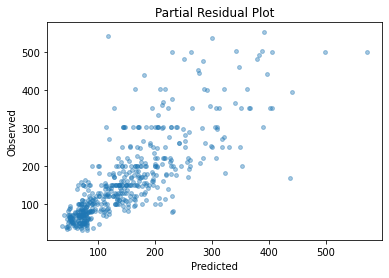

In [ ]:
param_grid = {'max_depth': [3],
              'learning_rate' : [0.1],
              'n_estimators': [200],
              'random_state' : [1]}

gbm = GridSearchCV(
    estimator = GradientBoostingRegressor(criterion='mse', subsample = 0.85),
    param_grid = param_grid, 
    scoring = 'neg_mean_squared_error', 
    cv = 10)

gbm.fit(X_train, y_train)

print(gbm.best_params_)
print("RMSE: {:.2f}".format(np.sqrt(mse(np.exp(y_test),np.exp(gbm.predict(X_test))))))
print("r2:  {:.2f}".format((r2(np.exp(y_test),np.exp(gbm.predict(X_test))))))

plt.scatter(np.exp(gbm.predict(X_test)), np.exp(y_test), alpha = 0.4, s = 15)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Partial Residual Plot")
plt.plot()

**XGBoost**

[01:33:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.39317
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:4.346
[2]	validation_0-rmse:4.29925
[3]	validation_0-rmse:4.25298
[4]	validation_0-rmse:4.20714
[5]	validation_0-rmse:4.16191
[6]	validation_0-rmse:4.11733
[7]	validation_0-rmse:4.07326
[8]	validation_0-rmse:4.02958
[9]	validation_0-rmse:3.98624
[10]	validation_0-rmse:3.94335
[11]	validation_0-rmse:3.90102
[12]	validation_0-rmse:3.85919
[13]	validation_0-rmse:3.8179
[14]	validation_0-rmse:3.77704
[15]	validation_0-rmse:3.73659
[16]	validation_0-rmse:3.69648
[17]	validation_0-rmse:3.65697
[18]	validation_0-rmse:3.61786
[19]	validation_0-rmse:3.57916
[20]	validation_0-rmse:3.54087
[21]	validation_0-rmse:3.50303
[22]	validation_0-rmse:3.4656
[23]	validation_0-rmse:3.42838
[24]	validation_0-rmse:3.39163
[25]	validation_0-rmse:3.35533
[26]	validation_

[]

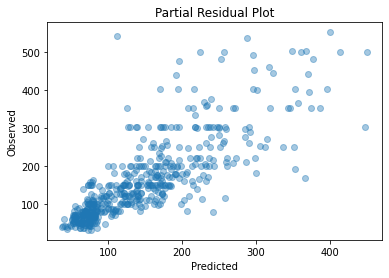

In [ ]:
param_grid = {'max_depth': [5],
              'learning_rate' : [0.011],
              'n_estimators': [10000],
              'gamma': [0],
              'alpha': [0],
              'reg_lambda': [1],
              'subsample' : [0.85],
              'scale_pos_weight': [1],
              'random_state' : [1]}

reg_xgb = GridSearchCV(
    estimator = XGBRegressor(missing = -999, criterion='mse'),
    param_grid = param_grid, 
    scoring = 'neg_mean_squared_error',
    cv = 5)

reg_xgb.fit(X_train_nan,
            y_train,
            eval_set = [(X_test_nan,y_test)], 
            eval_metric ='rmse', 
            verbose = True, 
            early_stopping_rounds = 20).best_params_

print(reg_xgb.best_params_)


print("RMSE: {:.2f}".format(np.sqrt(mse(np.exp(y_test),np.exp(reg_xgb.predict(X_test_nan))))))
print("r2:  {:.2f}".format((r2(np.exp(y_test),np.exp(reg_xgb.predict(X_test_nan))))))


plt.scatter(np.exp(reg_xgb.predict(X_test_nan)), np.exp(y_test), alpha = 0.4)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Partial Residual Plot")
plt.plot()

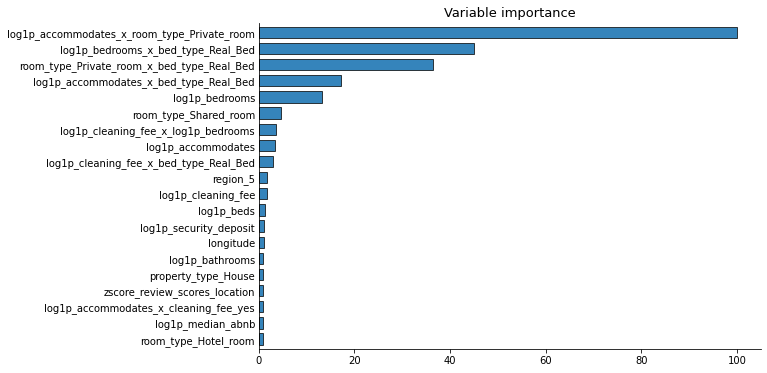

In [ ]:
from statlearning import plot_feature_importance

plot_feature_importance(reg_xgb.best_estimator_, X_train.keys())
plt.show()

**Decision tree**

Optimal nodes: 5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


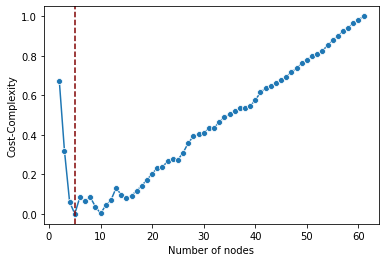

In [ ]:
Score = []
K = range(2,len(X_train_unscaled.keys()))
for k in K:
  d_tree = DecisionTreeRegressor(random_state=0, max_leaf_nodes=k, min_samples_leaf = 15)
  d_tree.fit(X_train_unscaled, np.exp(y_train))
  Score.append(np.sqrt(mse(np.exp(y_test),(d_tree.predict(X_test_unscaled)))) + k * 0.3)

Score = Score - np.min(Score)
Score = Score/np.max(Score)


sns.lineplot(K, Score, marker = "o").set(xlabel = "Number of nodes", ylabel = "Cost-Complexity")


g = np.min(Score)
min_k = np.where(Score == g)
min_k = int(min_k[0]) + 2
print("Optimal nodes: {:.0f}".format(min_k))
plt.axvline(min_k, color='maroon', linestyle = 'dashed')

{'min_samples_leaf': 1}
RMSE: 74.65
r2:  0.52


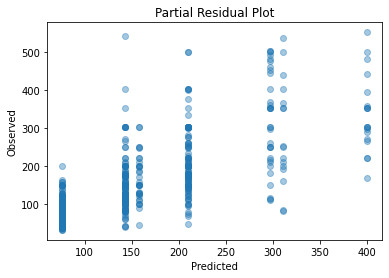

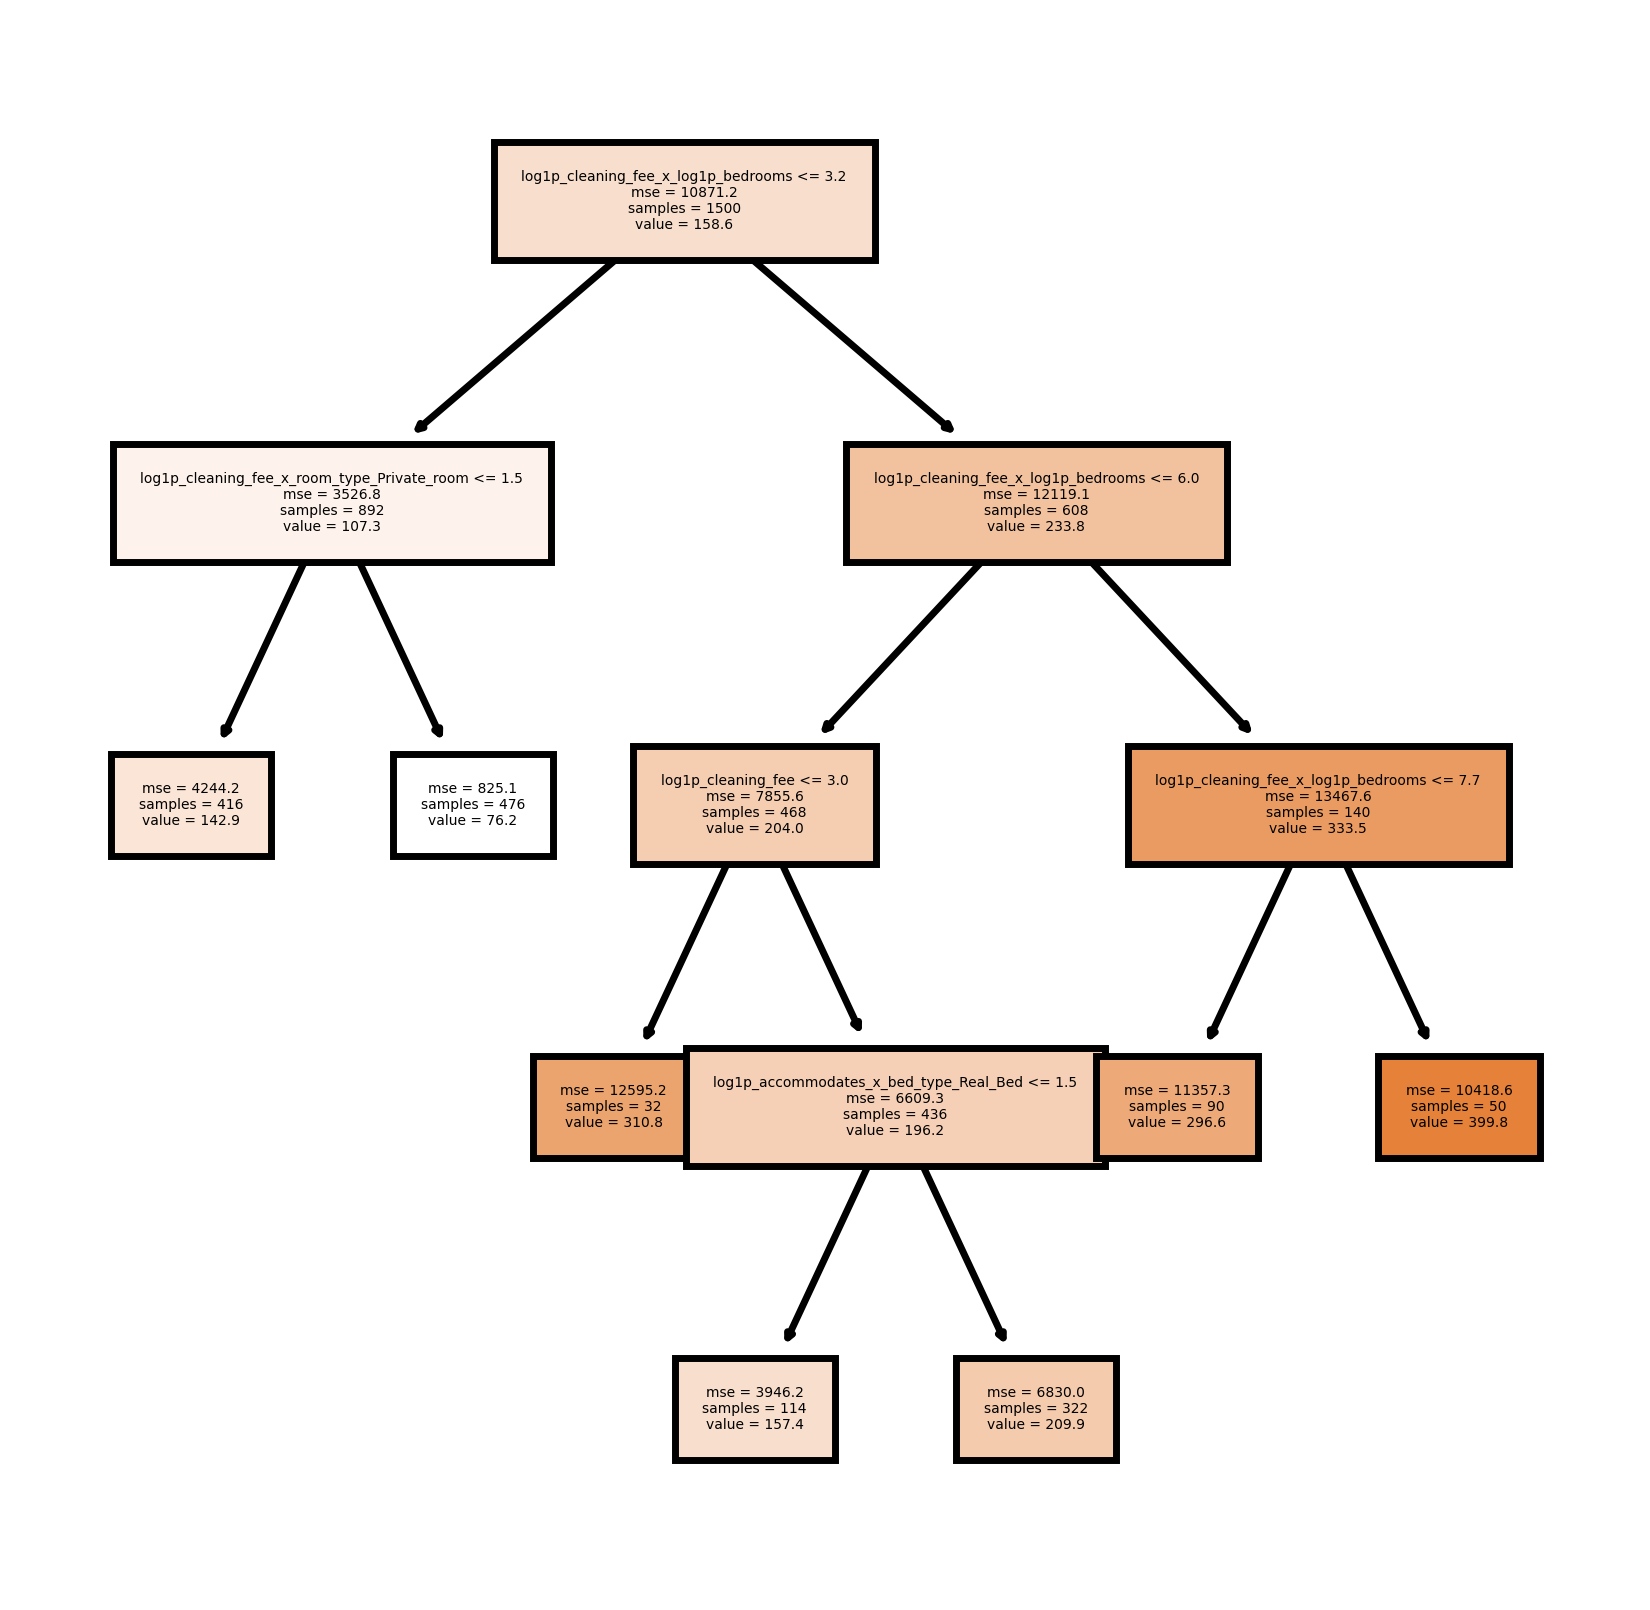

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=7,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:

model = DecisionTreeRegressor(random_state = 0, max_leaf_nodes = 7)


params = {
    'min_samples_leaf' : [1,2,10,100,1000],
}


d_treee = GridSearchCV(model, params, cv = 5)
d_treee.fit(X_train_unscaled, np.exp(y_train))
d_tree = d_treee.best_estimator_
print(d_treee.best_params_)

print("RMSE: {:.2f}".format(np.sqrt(mse(np.exp(y_test),(d_tree.predict((X_test_unscaled)))))))
print("r2:  {:.2f}".format((r2(np.exp(y_test),(d_tree.predict((X_test_unscaled)))))))

plt.scatter((d_tree.predict((X_test_unscaled))), np.exp(y_test), alpha = 0.4)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Partial Residual Plot")

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=500)
tree.plot_tree(d_tree, filled = True, feature_names = X_train_unscaled.keys(), fontsize = 2, precision = 1)
plt.show()

d_tree.fit(X_train, y_train)

**Elastic Net**

RMSE: 66.61
r2:  0.62
intercept:  5.586


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.686260611917824, tolerance: 0.058141276546640815
  positive)


coef
host_response_rate                         -0.076
host_acceptance_rate                        0.060
latitude                                   -0.011
longitude                                   0.131
review_scores_rating                        0.135
...                                           ...
region_2                                   -0.082
region_3                                   -0.149
region_4                                    0.032
region_5                                   -0.023
room_type_Private_room_x_bed_type_Real_Bed -0.039

[61 rows x 1 columns]

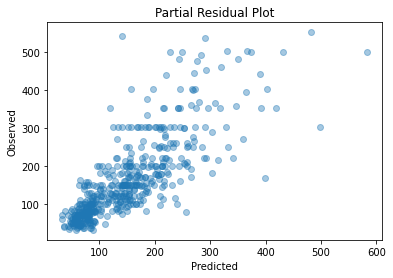

In [ ]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha = 0.0001, l1_ratio = 0.3)
enet.fit(X_train, y_train)

print("RMSE: {:.2f}".format(np.sqrt(mse(np.exp(y_test),np.exp(enet.predict(X_test))))))
print("r2:  {:.2f}".format((r2(np.exp(y_test),np.exp(enet.predict(X_test))))))



plt.scatter(np.exp(enet.predict(X_test)), np.exp(y_test), alpha = 0.4)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Partial Residual Plot")
plt.plot()

Score = []

i = 0
for i in range(len(X_test.keys())):
    Score.append(enet.coef_[i])

print("intercept:  {:.3f}".format(enet.intercept_))


output = pd.DataFrame(Score, index = X_test.keys())
std = pd.DataFrame(df.std(axis=0)).T
std = std.replace([std.iloc[:,30:].to_numpy()],1).T
output = output.merge(std, right_index = True, left_index = True)
output['coef'] = output['0_x'] / 1
output = output.drop(columns = ['0_y', '0_x'])
output = output[(output != 0).all(1)]
output.round(3)

**K-Nearest**

{'leaf_size': 1, 'n_neighbors': 14}
RMSE: 70.58
r2:  0.57


[]

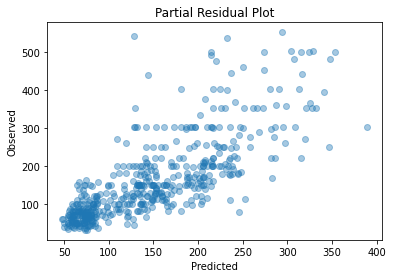

In [ ]:
param_grid = {'n_neighbors': [14,16,18],
             'leaf_size': [1,2,3]}

knn = GridSearchCV(
    estimator = KNeighborsRegressor(),
    param_grid = param_grid, 
    scoring = 'neg_mean_squared_error', 
    cv = 3)

knn.fit(X_train, y_train)
print(knn.best_params_)

print("RMSE: {:.2f}".format(np.sqrt(mse(np.exp(y_test),np.exp(knn.predict(X_test))))))
print("r2:  {:.2f}".format((r2(np.exp(y_test),np.exp(knn.predict(X_test))))))


plt.scatter(np.exp(knn.predict(X_test)), np.exp(y_test), alpha = 0.4)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Partial Residual Plot")
plt.plot()

**Stacked Model**

In [ ]:
from mlxtend.regressor import StackingCVRegressor

models = [reg_xgb, enet, gbm]

stack = StackingCVRegressor(models, meta_regressor = LinearRegression(), cv = 5)
stack.fit(np.array(X_train), y_train)

[01:49:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:50:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:50:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:52:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:53:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.399838725040325, tolerance: 0.047111993820628174
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.575200540393922, tolerance: 0.046478549246037476
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.311179746932716, tolerance: 0.046788507839123666
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

[02:05:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:05:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:06:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:07:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:08:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.686260611917824, tolerance: 0.058141276546640815
  positive)


StackingCVRegressor(cv=5,
                    meta_regressor=LinearRegression(copy_X=True,
                                                    fit_intercept=True,
                                                    n_jobs=None,
                                                    normalize=False),
                    n_jobs=None, pre_dispatch='2*n_jobs', random_state=None,
                    refit=True,
                    regressors=[GridSearchCV(cv=5, error_score=nan,
                                             estimator=XGBRegressor(base_score=0.5,
                                                                    booster='gbtree',
                                                                    colsample_bylevel=1,
                                                                    colsample_bynode=1,
                                                                    colsample_bytree=1,
                                                                    criterion...
         

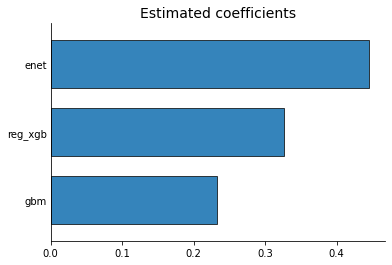

In [ ]:
from statlearning import plot_coefficients

plot_coefficients(stack.meta_regr_, labels = ['reg_xgb', 'enet', 'gbm'])
plt.show()

In [ ]:
y_fit = stack.predict(np.array(X_train))
bias = np.mean(np.exp(y_train - y_fit))
print("RMSE: {:.2f}".format(np.sqrt(mse(np.exp(y_test),np.exp(stack.predict(np.array(X_test)))*bias))))

y_objective = np.exp(stack.predict(np.array(X_objective))) * bias

output = pd.DataFrame(y_objective)
output.index.name = 'Id'
output.rename(columns = {0: "price"}, inplace = True)

output.tail()

RMSE: 63.96


price
Id              
1995  376.018803
1996  309.743287
1997  144.481671
1998   71.527489
1999   64.514738

In [ ]:
output.to_csv("submission.csv")

# Model Evaluation

# New Section

In [ ]:
columns = ['RMSE', 'R-Squared']
rows = ['Gradient Boost', 'XG Boost','Ridge Regression', 'Tree', 'K-Nearest Neighbours', 'ENET', 'Lasso']
results = pd.DataFrame(0.0, columns = columns, index = rows)

methods = [gbm, reg_xgb, d_tree, ridge, knn, enet, lasso]

for i, method in enumerate(methods):
  if method == reg_xgb:
    y_pred = method.predict(X_test_nan)
    results.iloc[i,0] = np.sqrt(mse(np.exp(y_test), np.exp(y_pred)))
    results.iloc[i,1] = r2(np.exp(y_test),np.exp(y_pred))
  elif method == d_tree:
    y_pred = method.predict(X_test_unscaled)
    results.iloc[i,0] = np.sqrt(mse(np.exp(y_test), (y_pred)))
    results.iloc[i,1] = r2(np.exp(y_test),np.exp(y_pred))
  else:
    y_pred = method.predict(X_test)
    results.iloc[i,0] = np.sqrt(mse(np.exp(y_test), np.exp(y_pred)))
    results.iloc[i,1] = r2(np.exp(y_test),np.exp(y_pred))

results.sort_values('RMSE', ascending = True).round(2)

# Selection and Debiasing

In [ ]:
# Enter the selected model

selected_model = gbm

RMSE: 64.78
r2:  0.64
bias:  1.022


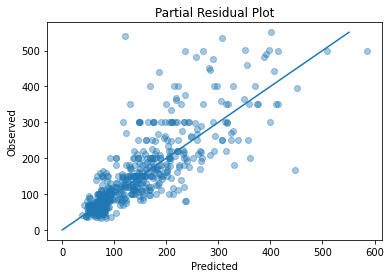

In [ ]:
if selected_model == reg_xgb:
  X_train1 = X_train_nan
  X_test1 = X_test_nan
  X_objective1 = X_objective_nan
elif selected_model == d_tree:
  X_train1 = X_train_unscaled
  X_test1 = X_test_unscaled
  X_objective1 = X_objective_unscaled
else:
  X_train1 = X_train
  X_test1 = X_test
  X_objective1 = X_objective

y_fit = selected_model.predict(X_train1)
bias = np.mean(np.exp(y_train - y_fit))

print("RMSE: {:.2f}".format(np.sqrt(mse(np.exp(y_test),np.exp(selected_model.predict(X_test1))*bias))))
print("r2:  {:.2f}".format((r2(np.exp(y_test),np.exp(selected_model.predict(X_test1))*bias))))
print("bias:  {:.3f}".format((bias)))


plt.scatter(np.exp(selected_model.predict(X_test1))*bias, np.exp(y_test), alpha = 0.4)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Partial Residual Plot")
plt.plot([0,np.exp(y_test).max()],[0,np.exp(y_test).max()])

# Final Prediction

In [ ]:
y_objective = np.exp(selected_model.predict(X_objective1)) * bias

output = pd.DataFrame(y_objective)
output.index.name = 'Id'
output.rename(columns = {0: "price"}, inplace = True)

output.tail()

In [ ]:
output.to_csv("submission.csv")